# Calibration of the Chaboche mecanical model


## Solution

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain,R,C,gamma = X
    stress = R + C * (1 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche) 

In [4]:
g.setInputDescription(["Strain","R","C","Gamma"])
g.setOutputDescription(["Stress"])

Define the random vector.

In [5]:
Strain = ot.Uniform(0,0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [6]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [7]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Stress] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

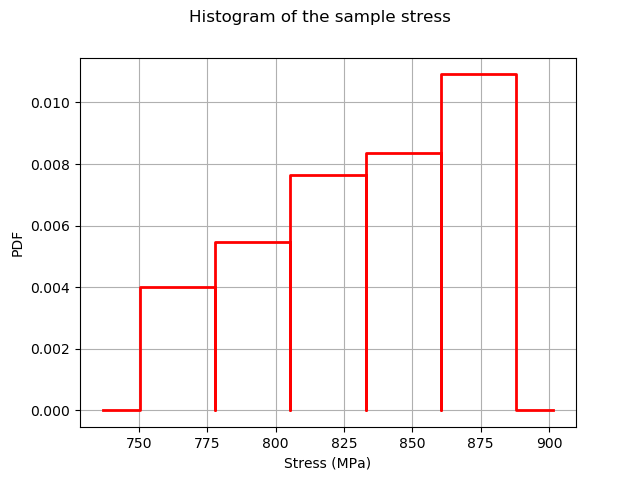

In [8]:
histoGraph = ot.HistogramFactory().build(outputStress/1.e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [9]:
stressObservationNoiseSigma = 10.e6 # (Pa)
noiseSigma = ot.Normal(0.,stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [10]:
observedStrain = inputSample[:,0]

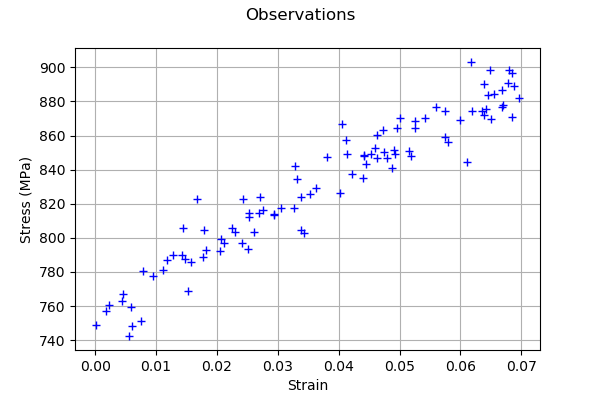

In [11]:
graph = ot.Graph("Observations","Strain","Stress (MPa)",True)
cloud = ot.Cloud(observedStrain,observedStress/1.e6)
graph.add(cloud)
graph

## A calibration analysis class

In [12]:
"""
A graphics class to analyze the results of calibration.
"""

import pylab as pl
import openturns as ot
import openturns.viewer as otv

class CalibrationAnalysis:
    def __init__(self,calibrationResult,model,inputObservations,outputObservations):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
    
        Parameters
        ----------
        calibrationResult : :class:`~openturns.calibrationResult`
            The result of a calibration.
    
        model : 2-d sequence of float
            The function to calibrate.
    
        inputObservations : :class:`~openturns.Sample`
            The sample of input values of the model linked to the observations.
    
        outputObservations : 2-d sequence of float
            The sample of output values of the model linked to the observations.
        """
        self.model = model
        self.outputAtPrior = None
        self.outputAtPosterior = None
        self.calibrationResult = calibrationResult
        self.observationColor = "blue"
        self.priorColor = "red"
        self.posteriorColor = "green"
        self.inputObservations = inputObservations
        self.outputObservations = outputObservations
        self.unitlength = 6 # inch
        # Compute yAtPrior
        meanPrior = calibrationResult.getParameterPrior().getMean()
        model.setParameter(meanPrior)
        self.outputAtPrior=model(inputObservations)
        # Compute yAtPosterior
        meanPosterior = calibrationResult.getParameterPosterior().getMean()
        model.setParameter(meanPosterior)
        self.outputAtPosterior=model(inputObservations)
        return None

    def drawParameterDistributions(self):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
        """
        thetaPrior = self.calibrationResult.getParameterPrior()
        thetaDescription = thetaPrior.getDescription()
        thetaPosterior = self.calibrationResult.getParameterPosterior()
        thetaDim = thetaPosterior.getDimension()
        fig = pl.figure(figsize=(12, 4))
        for i in range(thetaDim):
            graph = ot.Graph("",thetaDescription[i],"PDF",True,"topright")
            # Prior distribution
            thetaPrior_i = thetaPrior.getMarginal(i)
            priorPDF = thetaPrior_i.drawPDF()
            priorPDF.setColors([self.priorColor])
            priorPDF.setLegends(["Prior"])
            graph.add(priorPDF)
            # Posterior distribution
            thetaPosterior_i = thetaPosterior.getMarginal(i)
            postPDF = thetaPosterior_i.drawPDF()
            postPDF.setColors([self.posteriorColor])
            postPDF.setLegends(["Posterior"])
            graph.add(postPDF)
            '''
            If the prior is a Dirac, set the vertical axis bounds to the posterior. 
            Otherwise, the Dirac set to [0,1], where the 1 can be much larger 
            than the maximum PDF of the posterior.
            '''
            if (thetaPrior_i.getName()=="Dirac"):
                # The vertical (PDF) bounds of the posterior
                postbb = postPDF.getBoundingBox()
                pdf_upper = postbb.getUpperBound()[1]
                pdf_lower = postbb.getLowerBound()[1]
                # Set these bounds to the graph
                bb = graph.getBoundingBox()
                graph_upper = bb.getUpperBound()
                graph_upper[1] = pdf_upper
                bb.setUpperBound(graph_upper)
                graph_lower = bb.getLowerBound()
                graph_lower[1] = pdf_lower
                bb.setLowerBound(graph_lower)
                graph.setBoundingBox(bb)
            # Add it to the graphics
            ax = fig.add_subplot(1, thetaDim, i+1)
            _ = otv.View(graph, figure=fig, axes=[ax])
        return fig
    
    def drawObservationsVsPredictions(self):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        """
        
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        graph = ot.Graph("","Observations","Predictions",True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            graph = self._drawObservationsVsPredictions1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])

        return graph

    def _drawObservationsVsPredictions1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        Can manage only 1D samples.
        """
        yDim = outputObservations.getDimension()
        ydescription = outputObservations.getDescription()
        xlabel = "%s Observations" % (ydescription[0])
        ylabel = "%s Predictions" % (ydescription[0])
        graph = ot.Graph("",xlabel,ylabel,True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            curve = ot.Curve(outputObservations, outputObservations)
            curve.setColor(self.observationColor)
            graph.add(curve)
        else:
            raise TypeError('Output observations are not 1D.')
        # Plot the predictions before
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Plot the predictions after
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph
    
    def drawResiduals(self):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        """    
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        yPriorSize = self.outputAtPrior.getSize()
        yPriorDim = self.outputAtPrior.getDimension()
        if (yDim==1):
            observationsError = self.calibrationResult.getObservationsError()
            graph = self._drawResiduals1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior,observationsError)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            observationsError = self.calibrationResult.getObservationsError()
            # In this case, we cannot draw observationsError ; just 
            # pass the required input argument, but it is not actually used.
            graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsError)
        else:
            observationsError = self.calibrationResult.getObservationsError()
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                observationsErrorYi = observationsError.getMarginal(i)
                graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsErrorYi)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawResiduals1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior,observationsError):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        Can manage only 1D samples.
        """    
        ydescription = outputObservations.getDescription()
        xlabel = "%s Residuals" % (ydescription[0])
        graph = ot.Graph("Residuals analysis",xlabel,"Probability distribution function",True,"topright")
        yDim = outputObservations.getDimension()
        yPriorDim = outputAtPrior.getDimension()
        yPosteriorDim = outputAtPrior.getDimension()
        if (yDim==1) and (yPriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPrior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.priorColor])
            residualPDF.setLegends(["Prior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output prior observations are not 1D.')
        if (yDim==1) and (yPosteriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPosterior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.posteriorColor])
            residualPDF.setLegends(["Posterior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output posterior observations are not 1D.')
        # Plot the distribution of the observation errors
        if (observationsError.getDimension()==1):
            # In the other case, we just do not plot
            obserrgraph = observationsError.drawPDF()
            obserrgraph.setColors([self.observationColor])
            obserrgraph.setLegends(["Observation errors"])
            graph.add(obserrgraph)
        return graph

    def drawObservationsVsInputs(self):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        """
        xSize = self.inputObservations.getSize()
        ySize = self.outputObservations.getSize()
        xDim = self.inputObservations.getDimension()
        yDim = self.outputObservations.getDimension()
        xdescription = self.inputObservations.getDescription()
        ydescription = self.outputObservations.getDescription()
        # Observations
        if (xDim==1) and (yDim==1):
            graph = self._drawObservationsVsInputs1Dimension(self.inputObservations,self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (xSize==1) and (ySize==1):
            inputObservations = ot.Sample(self.inputObservations[0],1)
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(xDim*self.unitlength, yDim*self.unitlength))
            for i in range(xDim):
                for j in range(yDim):
                    k = xDim * j + i
                    inputObservations = self.inputObservations[:,i]
                    outputObservations = self.outputObservations[:,j]
                    outputAtPrior = self.outputAtPrior[:,j]
                    outputAtPosterior = self.outputAtPosterior[:,j]
                    graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
                    ax = fig.add_subplot(yDim, xDim, k+1)
                    _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawObservationsVsInputs1Dimension(self,inputObservations,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        Can manage only 1D samples.
        """
        xDim = inputObservations.getDimension()
        if (xDim!=1):
            raise TypeError('Input observations are not 1D.')
        yDim = outputObservations.getDimension()
        xdescription = inputObservations.getDescription()
        ydescription = outputObservations.getDescription()
        graph = ot.Graph("",xdescription[0],ydescription[0],True,"topright")
        # Observations
        if (yDim==1):
            cloud = ot.Cloud(inputObservations,outputObservations)
            cloud.setColor(self.observationColor)
            cloud.setLegend("Observations")
            graph.add(cloud)
        else:
            raise TypeError('Output observations are not 1D.')
        # Model outputs before calibration
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Model outputs after calibration
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [13]:
R = 700e6 # Exact : 750e6
C = 2500e6 # Exact : 2750e6
Gamma = 8. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

In [14]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point.

In [15]:
algo = ot.LinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior,"SVD")

The `run` method computes the solution of the problem.

In [16]:
algo.run()

In [17]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [18]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.47737e+08,2.79045e+09,10.3362]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [19]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.39694e+08,2.24973e+09,-530.441] upper bound=class=Point name=Unnamed dimension=3 values=[7.55779e+08,3.33117e+09,551.114] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

In [20]:
mypcr = CalibrationAnalysis(calibrationResult, mycf, observedStrain, observedStress)

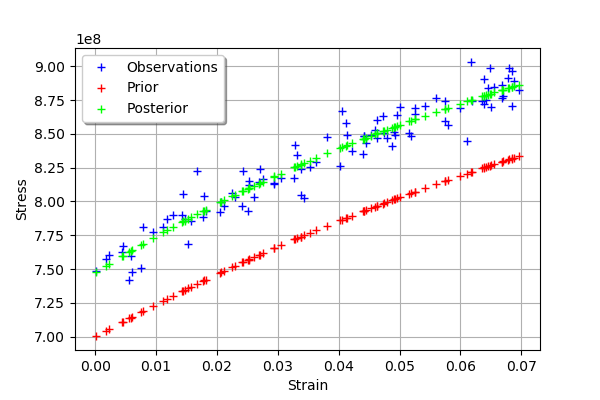

In [21]:
graph = mypcr.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

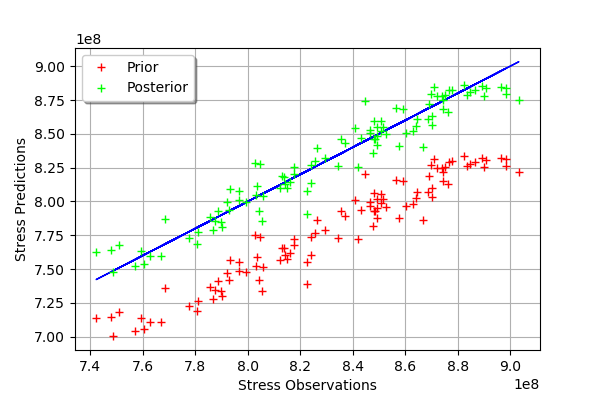

In [22]:
mypcr.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [23]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1.10416e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

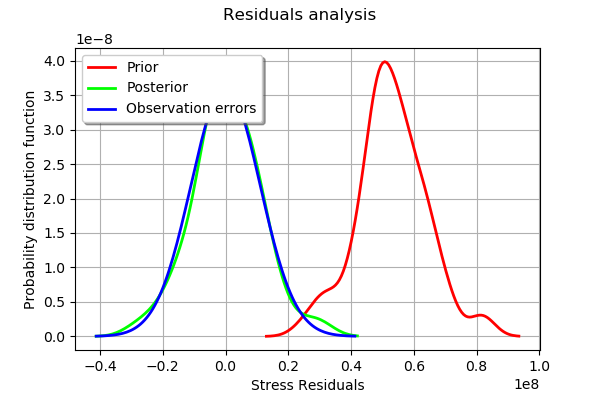

In [24]:
graph = mypcr.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. 

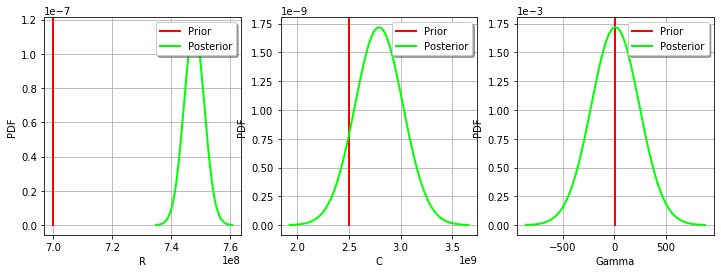

In [25]:
_ = mypcr.drawParameterDistributions()

## Calibration with nonlinear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [26]:
algo = ot.NonLinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior)

The `run` method computes the solution of the problem.

In [27]:
algo.run()

In [28]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [29]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.48444e+08,2.74804e+09,9.78149]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [30]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.40173e+08,2.11479e+09,2.9595] upper bound=class=Point name=Unnamed dimension=3 values=[7.57679e+08,3.48123e+09,17.3487] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

In [31]:
mypcr = CalibrationAnalysis(calibrationResult,mycf, observedStrain, observedStress)

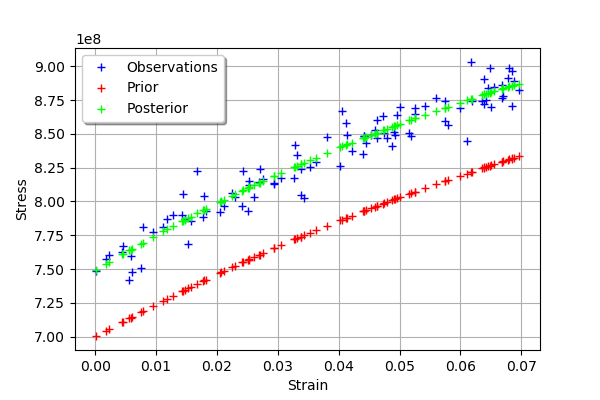

In [32]:
graph = mypcr.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

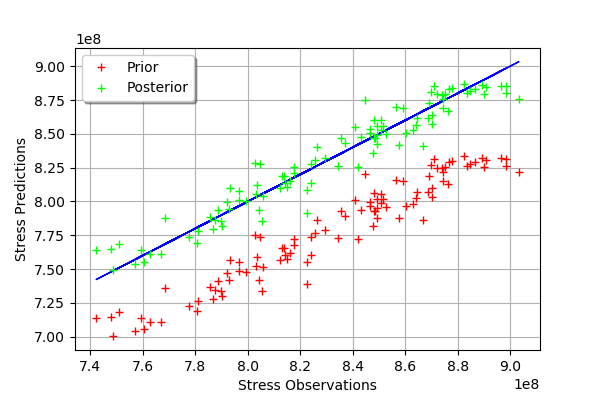

In [33]:
mypcr.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [34]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[3573.98] sigma=class=Point name=Unnamed dimension=1 values=[1.09955e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

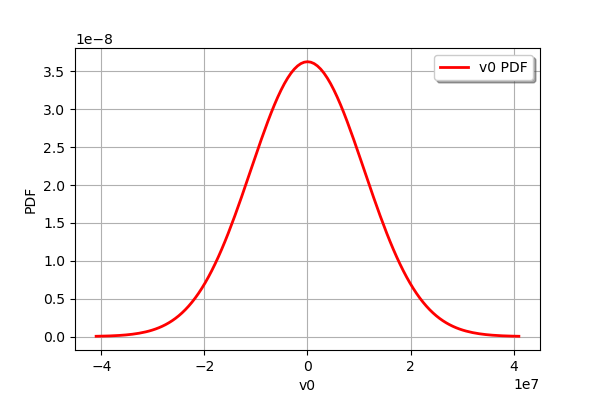

In [35]:
observationError.drawPDF()

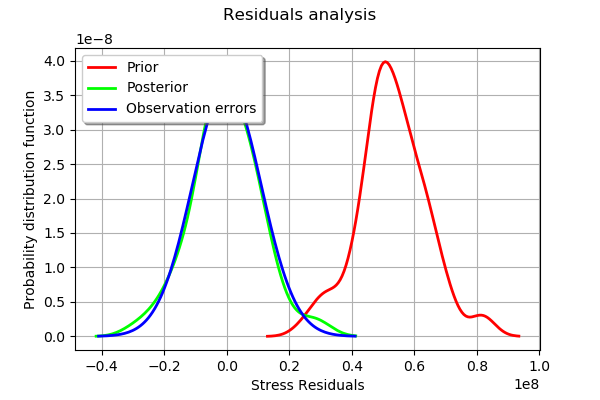

In [36]:
graph = mypcr.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. This indicates that the observation error might be gaussian.

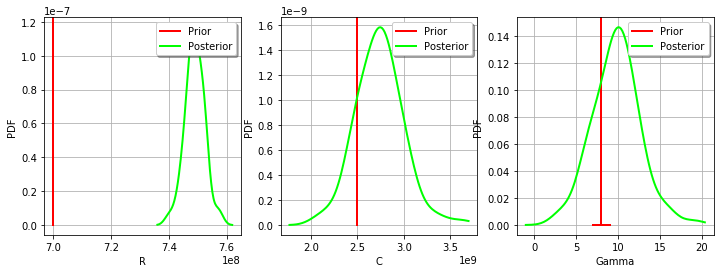

In [37]:
_ = mypcr.drawParameterDistributions()

## Exercice 1 : changement du paramètre de référence

* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [38]:
R = 650e6 # Exact : 750e6
C = 2300e6 # Exact : 2750e6
Gamma = 6. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])

* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés linéaires ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés non-linéaires ? Pouvez-vous expliquer les causes de ces différences ?

## Solution de l'exercice 1 : changement du paramètre de référence

In [39]:
def calageChabocheParMoindresCarresLineaires(thetaPrior):
    '''Calage du modèle de Chaboche par moindres 
    carrés linéaires. 

    Arguments:
        thetaPrior : la valeur de référence
    Retourne
        thetaMAP : l'estimateur MAP
    '''
    algo = ot.LinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior,"SVD")
    algo.run()
    calibrationResult = algo.getResult()
    thetaMAP = calibrationResult.getParameterMAP()
    print("LinearLeastSquaresCalibration")
    print("R*=%.1f (MPa)" % (thetaMAP[0]/1.e6))
    print("C*=%.0f (MPa)" % (thetaMAP[1]/1.e6))
    print("Gamma*=%.3f" % (thetaMAP[2]))
    return thetaMAP

In [40]:
R = 700e6 # Exact : 750e6
C = 2500e6 # Exact : 2750e6
Gamma = 8. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])
thetaMAP1 = calageChabocheParMoindresCarresLineaires(thetaPrior)

LinearLeastSquaresCalibration
R*=747.7 (MPa)
C*=2790 (MPa)
Gamma*=10.336


In [41]:
R = 650e6 # Exact : 750e6
C = 2300e6 # Exact : 2750e6
Gamma = 6. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])
thetaMAP2 = calageChabocheParMoindresCarresLineaires(thetaPrior)

LinearLeastSquaresCalibration
R*=750.6 (MPa)
C*=2568 (MPa)
Gamma*=8.090


In [42]:
print("Ecart relatif")
for i in range(thetaMAP1.getDimension()):
    delta = abs(thetaMAP1[i] - thetaMAP2[i])/thetaMAP1[i]
    print("Delta %i = %.5f" % (i,delta))

Ecart relatif
Delta 0 = 0.00383
Delta 1 = 0.07978
Delta 2 = 0.21731


On observe :
* un petit écart sur $\hat{R}$,
* un écart moyen sur $\hat{C}$ et $\hat{\gamma}$.

La cause de ces différences est due aux facteurs suivants.
* Le modèle est linéarisé au voisinage du point `thetaPrior`, en évaluant la Jacobienne de la fonction $h$ en ce point. Or le modèle est presque linéaire, mais pas exactement. Cela génère des petites différences dans la matrice Jacobienne, ce qui implique des changements dans la solution du problème. 
* Le modèle est très sensible a des changements dans R, mais moins à des changements dans C et Gamma. Puisque les observations sont les mêmes dans les deux cas, cela implique que la solution optimale $\hat{R}$ est peu sensible au point où la fonction $h$ est linéarisée, au contraire de $\hat{C}$ et $\hat{\gamma}$. 

In [43]:
def calageChabocheParMoindresCarresNonLineaires(thetaPrior):
    '''Calage du modèle de Chaboche par moindres 
    carrés non linéaires. 

    Arguments:
        thetaPrior : la valeur de référence
    Retourne
        thetaMAP : l'estimateur MAP
    '''
    algo = ot.NonLinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior)
    algo.run()
    calibrationResult = algo.getResult()
    thetaMAP = calibrationResult.getParameterMAP()
    print("NonLinearLeastSquaresCalibration")
    print("R*=%.1f (MPa)" % (thetaMAP[0]/1.e6))
    print("C*=%.0f (MPa)" % (thetaMAP[1]/1.e6))
    print("Gamma*=%.3f" % (thetaMAP[2]))
    return thetaMAP

In [44]:
R = 700e6 # Exact : 750e6
C = 2500e6 # Exact : 2750e6
Gamma = 8. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])
thetaMAP1 = calageChabocheParMoindresCarresNonLineaires(thetaPrior)

NonLinearLeastSquaresCalibration
R*=748.4 (MPa)
C*=2748 (MPa)
Gamma*=9.781


In [45]:
R = 650e6 # Exact : 750e6
C = 2300e6 # Exact : 2750e6
Gamma = 6. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])
thetaMAP2 = calageChabocheParMoindresCarresNonLineaires(thetaPrior)

NonLinearLeastSquaresCalibration
R*=749.5 (MPa)
C*=2657 (MPa)
Gamma*=8.819


In [46]:
print("Ecart relatif")
for i in range(thetaMAP1.getDimension()):
    delta = abs(thetaMAP1[i] - thetaMAP2[i])/thetaMAP1[i]
    print("Delta %i = %.5f" % (i,delta))

Ecart relatif
Delta 0 = 0.00144
Delta 1 = 0.03305
Delta 2 = 0.09837


On observe des petits écarts sur $\hat{R}$, $\hat{C}$ et $\hat{\gamma}$.

Cela montre que, contrairement aux moindres carrés linéaires, la solution du problème de moindres carrés non linéaires est peu sensible au changement dans le point de départ de l'algorithme. 
* En effet, les moindres carrés non linéaires ne procèdent pas à une linéarisation du modèle. 
* D'autre part, cette expérience montre que le problème semble plutôt facile à résoudre, au contraire de certains problèmes de moindres carrés qui possèdent parfois plusieurs optimums locaux. 

## Exercice 2 : réduire la dimension

Au lieu d'ajuster les paramètres R, C et Gamma, on se propose d'ajuster uniquement R et C en utilisant la valeur de Gamma suivante :

In [47]:
Gamma = 8. # Exact : 10

Pour cela, utiliser le code suivant, qui permet de définir un modèle dont les seuls paramètres sont R et C.

In [48]:
def modelChabocheGammaFixe(X):
    strain,R,C = X
    gamma = 8.
    stress = R + C * (1 - np.exp(-gamma * strain)) / gamma
    return [stress]

gGammaFixe = ot.PythonFunction(3, 1, modelChabocheGammaFixe)

R = 700e6 # Exact : 750e6
C = 2500e6 # Exact : 2750e6
thetaPriorGammaFixe = ot.Point([R,C])

calibratedIndices = [1,2]
mycfGammaFixe = ot.ParametricFunction(gGammaFixe, calibratedIndices, thetaPriorGammaFixe)

On considère dans les questions qui suivent un calage par moindres carrés linéaires.

* Quelle est la valeur du paramètre optimal ? Quels sont les changements par rapport à la situation précédente, dans laquelle le paramètre Gamma était calé ?
* Quelle est la qualité du calage obtenu ?
* Qu'est-ce que ces changements impliquent du point de vue du modèle ?

## Solution de l'exercice 2 : réduire la dimension

In [49]:
algo = ot.LinearLeastSquaresCalibration(mycfGammaFixe, observedStrain, observedStress, thetaPriorGammaFixe,"SVD")
algo.run()
calibrationResult = algo.getResult()
thetaMAPGammaFixe1 = calibrationResult.getParameterMAP()
print("LinearLeastSquaresCalibration")
print("R*=%.1f (MPa)" % (thetaMAPGammaFixe1[0]/1.e6))
print("C*=%.0f (MPa)" % (thetaMAPGammaFixe1[1]/1.e6))

LinearLeastSquaresCalibration
R*=749.8 (MPa)
C*=2596 (MPa)


On observe que ces paramètres restent dans les intervalles de confiance que nous avions déterminé précédemment.

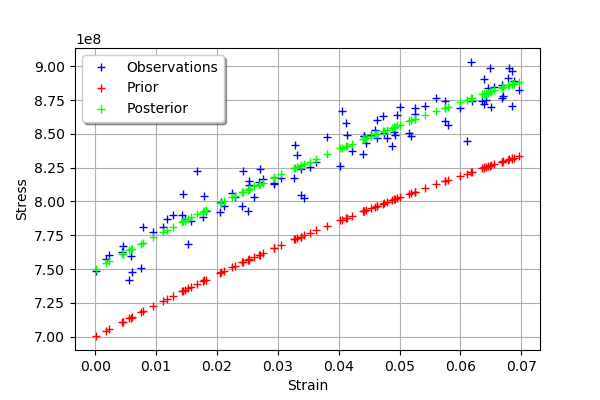

In [50]:
mypcr = CalibrationAnalysis(calibrationResult, mycfGammaFixe, observedStrain, observedStress)
graph = mypcr.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

On observe que le calage est tout aussi satisfaisant que précédemment, lorsque le paramètre Gamma était calé. De toute évidence, le paramètre Gamma n'est pas très influent dans ce modèle de telle sorte qu'on peut, sous réserve que le fixer à une valeur qui n'est pas aberrante, le considérer comme une constante sans impact. 

## Exercice 3 : calage et indices de Sobol'

On souhaite observer le lien entre calage et analyse de sensibilité globale. En effet, il semble que les variables R, C et Gamma n'ont pas le même effet sur le modèle. En particulier, il semble que la distribution gaussienne du paramètre Gamma optimal est extrêment large dans le cas des moindres carrés linéaires. 

Pour cette raison, on créer un nouveau modèle `myFunctionH` dont les entrées sont les variables R, C et Gamma. Dans ce modèle, la déformation `Strain` est considérée comme constante et égale à la déformation maximale. Ce choix de paramétrage permet de se situer dans la plage de variation dans laquelle le modèle est le plus nonlinéaire. 

In [51]:
strainReferenceValue = ot.Point([0.07])
strainReferenceValue

class=Point name=Unnamed dimension=1 values=[0.07]

In [52]:
strainIndex = [0]
myFunctionH = ot.ParametricFunction(g, strainIndex, strainReferenceValue)
myFunctionH

class=FunctionImplementation name=Unnamed description=[R,C,Gamma,Stress] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3]

La distribution des paramètres R, C et Gamma est inconnue. Dans ce contexte, nous considérons des distributions gaussiennes associés à un coefficient de variation de 20%.

In [53]:
def NormalFromMuCV(mu,cv):
    '''Create a Normal from its mean and its coeff. of var.'''
    sigma = mu * cv
    distribution = ot.Normal(mu,sigma)
    return distribution

In [54]:
cv = 0.2
R = NormalFromMuCV(650.e6,cv)
R.setDescription(["R"])
C = NormalFromMuCV(2300.e6,cv)
C.setDescription(["C"])
Gamma = NormalFromMuCV(6.0,cv)
Gamma.setDescription(["Gamma"])
inputDistribution = ot.ComposedDistribution([R,C,Gamma])

On souhaite désormais estimer la sensibilité de la fonction `myFunctionH`  en fonction des entrées R, C et Gamma. 
* Estimer les indices de sensibilité de Sobol' de la fonction `myFunctionH` par rapport à R, C et Gamma. Pour cela, utiliser la classe `SobolSimulationAlgorithm` associée à l'estimateur `SaltelliSensitivityAlgorithm`.
* Quelles sont les variables influentes et peu influentes ?
* Que conclure par rapport au calage ?

## Solution de l'exercice 3 : calage et indices de Sobol'

In [55]:
def drawMarginals(distribution):
    import openturns.viewer as otv
    for index in range(distribution.getDimension()):
        marginal = distribution.getMarginal(index)
        graph = marginal.drawPDF()
        otv.View(graph)
    return None

Note : La classe `SobolSimulationAlgorithm` n'a pas de méthode draw.

Référence : https://github.com/openturns/openturns/issues/1001

Note : La classe `Text` a un problème avec la taille.

https://github.com/openturns/openturns/issues/1351

In [56]:
def plotSobolSimulationResult(sobolSimulationResult,input_names,alpha=0.05):
    fo = sobolSimulationResult.getFirstOrderIndicesEstimate()
    to = sobolSimulationResult.getTotalOrderIndicesEstimate()
    dist_fo = sobolSimulationResult.getFirstOrderIndicesDistribution()
    dist_to = sobolSimulationResult.getTotalOrderIndicesDistribution()
    dim = dist_to.getDimension()
    graph = ot.Graph("Sobol' sensivity indices","Inputs","Sensivity indices",True,"topright")
    # Indices
    curve = ot.Cloud(range(dim),fo)
    curve.setColor("red")
    curve.setLegend("First order")
    graph.add(curve)
    curve = ot.Cloud(range(dim),to)
    curve.setColor("blue")
    curve.setLegend("Total order")
    graph.add(curve)
    # Labels
    x = ot.Point(range(dim)) + ot.Point([0.1]*dim)
    text = ot.Text(x, to, input_names)
    text.setTextSize(1.0)
    text.setColor("red")
    graph.add(text)
    # Error bars
    for i in range(dim):
        dist_fo_i = dist_fo.getMarginal(i)
        dist_to_i = dist_to.getMarginal(i)
        fo_ci = dist_fo_i.computeBilateralConfidenceInterval(1-2*alpha)
        to_ci = dist_to_i.computeBilateralConfidenceInterval(1-2*alpha)
        fo_a = fo_ci.getLowerBound()[0]
        fo_b = fo_ci.getUpperBound()[0]
        to_a = to_ci.getLowerBound()[0]
        to_b = to_ci.getUpperBound()[0]
        curve = ot.Curve([i,i],[fo_a,fo_b])
        curve.setColor("red")
        graph.add(curve)
        curve = ot.Curve([i,i],[to_a,to_b])
        curve.setColor("blue")
        graph.add(curve)
    # Set bounds to the graph
    bb = graph.getBoundingBox()
    graph_upper = bb.getUpperBound()
    graph_upper[1] = 1.1
    bb.setUpperBound(graph_upper)
    graph_lower = bb.getLowerBound()
    graph_lower[1] = -0.1
    bb.setLowerBound(graph_lower)
    graph.setBoundingBox(bb)
    return graph

In [57]:
def computeSobolIndices(inputDistribution,model):
    alpha = 0.05 # i.e. 90% confidence interval
    epsilon = 0.1 # Confidence interval length
    blocksize = 1000 # size of Sobol experiment at each iteration
    batchsize = 100 # number of points evaluated simultaneously
    estimator = ot.SaltelliSensitivityAlgorithm()
    estimator.setUseAsymptoticDistribution(True)
    memoizedModel = ot.MemoizeFunction(model)
    numberOfEvaluationsBefore = memoizedModel.getInputHistory().getSize()
    algo = ot.SobolSimulationAlgorithm(inputDistribution, memoizedModel, estimator)
    algo.setMaximumOuterSampling(100) # number of iterations
    algo.setBlockSize(blocksize) 
    algo.setBatchSize(batchsize) 
    algo.setIndexQuantileLevel(alpha) # alpha
    algo.setIndexQuantileEpsilon(epsilon) # epsilon
    algo.run()
    numberOfEvaluationsAfter = memoizedModel.getInputHistory().getSize()
    numberOfEvaluations = numberOfEvaluationsAfter - numberOfEvaluationsBefore
    result = algo.getResult()
    firstOrderIndices = result.getFirstOrderIndicesEstimate()
    totalOrderIndices = result.getTotalOrderIndicesEstimate()
    print("First order = %s" % (str(firstOrderIndices)))
    print("Total order = %s" % (str(totalOrderIndices)))
    print("Number of evaluations=",numberOfEvaluations)
    input_names = inputDistribution.getDescription()
    import openturns.viewer as otv
    graph = plotSobolSimulationResult(result,input_names)
    otv.View(graph)
    return None

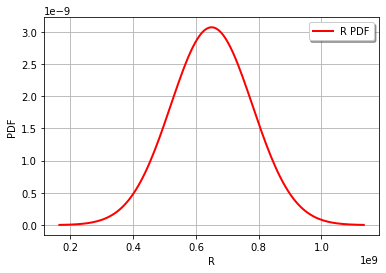

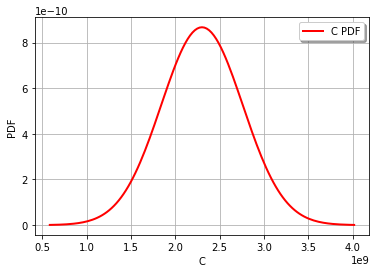

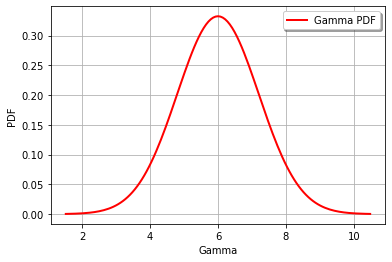

In [58]:
drawMarginals(inputDistribution)

First order = [0.957897,0.0382562,0.00230836]
Total order = [0.957074,0.0421945,0.00223415]
Number of evaluations= 60000


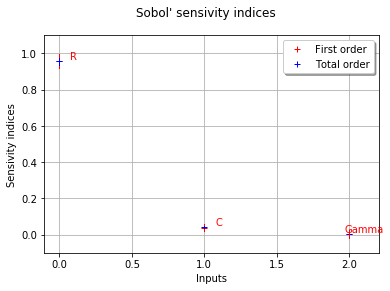

In [59]:
computeSobolIndices(inputDistribution,myFunctionH)

Le modèle est très peu sensible à la variation de la variable Gamma. Au contraire, le modèle est très sensible à des variations dans R et moyennement sensible à C. C'est pourquoi il est surtout important de caler les paramètres R et C. 

## Exercice 4 : linéarité du modèle

On observe que le calage linéaire donne des résultats proches du calage non linéaire en termes de valeurs optimales, mais que les distributions des paramètres optimaux estimés sont assez différentes. C'est pourquoi on souhaite voir à quel point la contrainte est linéaire en fonction de R, C et Gamma, i.e. on souhaite voit si la fonction `myFunctionH` est linéaire par rapport à R, C et Gamma.  

* Créer un échantillon d'entrée de taille 1000 à partir de la distribution `inputDistribution`. 
* Créer un échantillon de sortie à partir de l'échantillon d'entrée précédent et de la fonction `myFunctionH`. 
* Utiliser la classe `LinearLeastSquares` et créer un modèle linéaire. 
* Calculer le coefficient R2: le modèle est-il approximativement linéaire ?
* Calculer les indices Standardized Regression Coefficients (SRC) de la fonction `myFunctionH` par rapport à Epsilon, R, C et Gamma. Sont ils proches des indices de Sobol' ?

## Solution de l'exercice 4 : linéarité du modèle

In [60]:
n = 1000
sampleX = inputDistribution.getSample(n)
sampleY = myFunctionH(sampleX)

In [61]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

In [62]:
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=3 values=[0,0,0] constant=class=Point name=Unnamed dimension=1 values=[7.76843e-10] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=1 values=[1.00006,0.0572565,4.70418e-09] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=1 values=[1.00006,0.0572565,4.70418e-09] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=3 columns=3 sheets=1 values=[0,0,0,0,0,0,0,0,0]

In [63]:
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)

In [64]:
q2 = val.computePredictivityFactor()
q2

0.9984869850538937

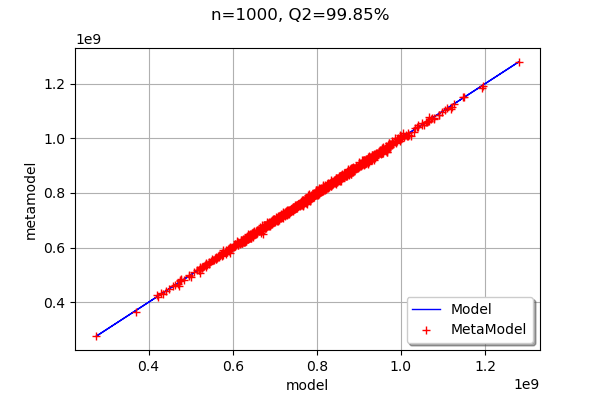

In [65]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n,q2*100))
graph

On observe que le coefficient Q2 est égal à seulement 68%. En conséquence, un tiers de la variabilité de la sortie n'est pas expliqué par le modèle linéaire. Cela montre que le modèle linéaire est plutôt une approximation insatisfaisante, sans être toutefois complètement mauvaise. 

In [66]:
SRCindices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
SRCindices

class=Point name=Unnamed dimension=3 values=[0.94897,0.0393987,7.37511e-38]

Cet écart est attendu car il est associé à l'erreur d'estimation des indices par la méthode d'échantillonnage.

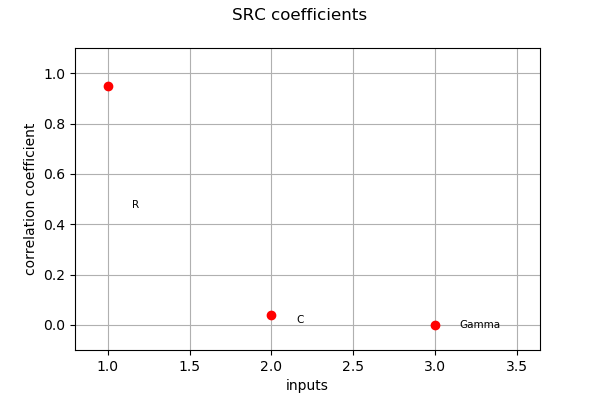

In [67]:
input_names = myFunctionH.getInputDescription()
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(SRCindices, input_names, "SRC coefficients")

On observe que le modèle linéaire est très peu sensible à la variable Gamma. Cela explique pourquoi le calage linéaire génère une distribution si large pour la variable Gamma. 